# BE/Bi 103, Fall 2015: Homework 5
## Due 1pm, Monday, November 9

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5.ipynb).*

In [20]:
import warnings

# The workhorses
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numdifftools as ndt

# Use Numba for speed
import numba

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth': 2.5})
sns.set_style('darkgrid', {'axes.facecolor': '(0.875, 0.875, 0.9)'})

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Problem 5.1: Dancing (80 pts)

*This problem was inspired by Geoff Cumming.*

In this problem, we will investigate how **replicable** certain statistical conclusions, both the frequentist and Bayesian contexts, are.  What I mean by replicability is best understood be working through the problem.

For this tutorial we will use the zebrafish embryo sleep data we have been using before.  We will investigate one of the metrics we considered in [Tutorial 2b](../tutotials/t2b_defining_and_estimating_parameters.html).  We will study the mean rest bout length on the third night, comparing wild type to the homozygous mutant.  You could work through Tutorial 2b again to process the bout lengths and get the data, but I provide them for you [here](../data/mean_rest_bouts.csv).

As a reminder, two of the mutant fish had no detectable rest bouts on the one-minute sampling interval.  They obviously did have rest bouts, but they were smaller than one minute.  We therefore have a decision: we can either choose the mean rest bout length to be zero for these fish, or we can jettison them from our samples because we know we could not properly sample them.  For the purposes of this problem, we will include these fish and take their mean bout length to be zero.

Let's remind ourselves of what the data look like.

In [21]:
# Load data
df = pd.read_csv('../data/gandhi_et_al/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant and take NaNs to be zero
df = df[df['genotype'].isin(['wt', 'mut'])].fillna(0)

Let's look at these data with a jitter plot.

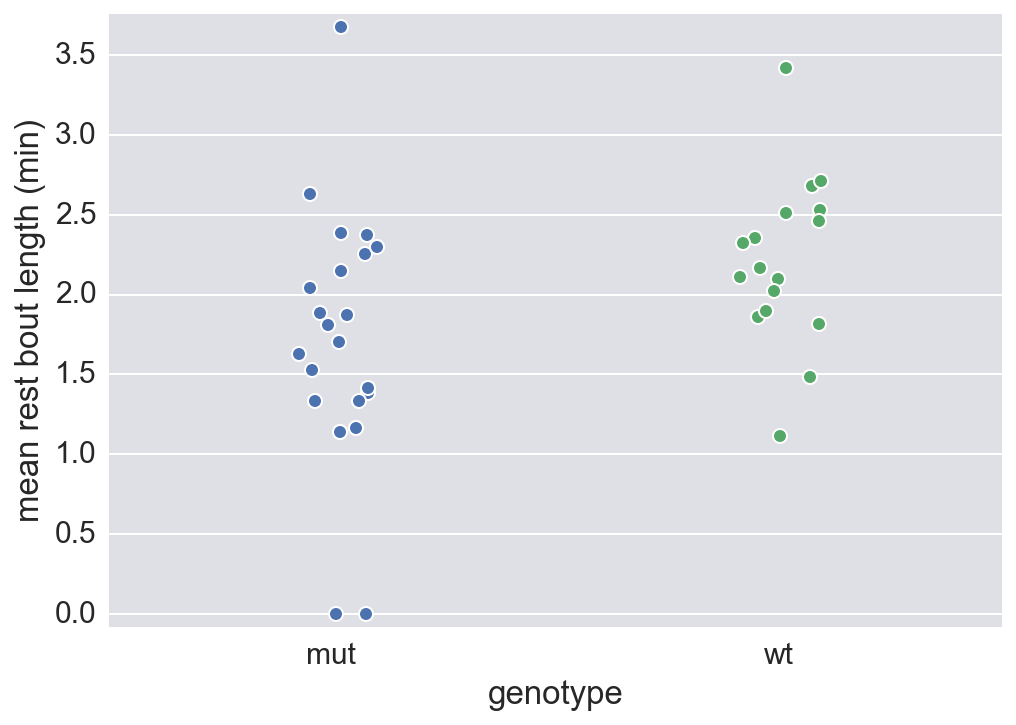

In [22]:
# Make strip plot
sns.stripplot(x='genotype', y='mean_rest_bout_length', data=df, jitter=True)

# Label axes 
plt.ylabel('mean rest bout length (min)')
plt.margins(y=0.02)

By eye, is looks like the wild type has a longer mean rest bout length than the mutant.  We will investigate this claim using parametric frequentist and Bayesian methods.  We will assume these data are Gaussian distributed each with their own mean $\mu$ and variance $\sigma^2$.

**a)** Estimate the values of $\mu$ and $\sigma^2$ for the wild type and mutant populations using an unbiased frequentist estimator.  We will denote these as $\mu_w$, $\sigma^2_w$, $\mu_m$, and $\sigma^2_m$.  Also compute Cohen's d to measure the effect size between these two.

**b)** Compute a frequentist estimate for the difference of the means, $\delta \equiv \mu_w - \mu_m$ and a reasonable 95% confidence interval.

**c)** Compute a reasonable Bayesian estimate for $\delta$ and give a credible region.

**d)** Consider the hypothesis $H_0$, which says that the (outlier-free) mutant and wild type populations are drawn from the same Gaussian distribution.  Perform a frequentist hypothesis test to compute the p-value corresponding to this hypothesis.

**e)** Consider hypothesis $H_1$ that says that they are drawn from different Gaussian distributions with their own mean $\mu$ and variance $\sigma^2$, as we assumed at the beginning.  Compute an approximate Bayesian odds ratio,

\begin{align}
O_{01} = \frac{P(H_0\mid D, I)}{P(H_1\mid D, I)}.
\end{align}

\textit{Hint}: Some of the results from lecture 2 might make this calculation easier.  In fact, you can use some fairly simple analytical results to quickly compute the odds ratio.  Or you have hit it with an MCMC hammer if you feel like giving your computer a workout.

**f)** We will now "repeat" the experiment.  Generate a set of mean sleep bout lengths for 17 wild type fish by drawing the bout lengths out of a Gaussian distribution with mean $\mu_w$ and variance $\sigma_w^2$, using the values you estimated in part (a).  Do the same for 22 mutant fish using $\mu_m$ and $\sigma_m$ as estimated in part (a).  For this new group of fish, repeat parts (b) through (e).  That is, compute the frequentist confidence interval for $\delta$, a Bayesian credible region for $\delta$, a frequentist p-value for hypothesis $H_0$, and a Bayesian odds ratio $O_{01}$.  

Do this procedure, where you generate new data from your mean and variances in part (a) and compute these quantities, 100 times.  Make plots that show how the confidence intervals, credible regions, p-values, and odds ratios "dance" as you repeat the experiment.  What lessons do you take away from this?

### Problem 5.1: solution
We will also consider the case where we drop the fish where we could not detect rest bouts to show the results are general.  In general, it will be easiest to split our two samples into NumPy arrays first.

In [23]:
# Load data
df = pd.read_csv('../data/gandhi_et_al/mean_rest_bouts.csv', comment='#')

# Pull out wild type and mutant
df = df[df['genotype'].isin(['wt', 'mut'])]

# For convenience, store each as a NumPy array, inserting zero for NaN
wt = df[df['genotype']=='wt']['mean_rest_bout_length'].values
mut = df[df['genotype']=='mut']['mean_rest_bout_length'].fillna(0).values
mut_no_zeros = df[df['genotype']=='mut']['mean_rest_bout_length'].dropna().values

**a)** We use an unbiased frequentist estimate for $\mu$ and $\sigma$, as derived in [Tutorial 6a](../tutorials/t6a_frequentist_parameter_estimation.html).  We'll also use the function we wrote to compute Cohen's d in [Tutorial 6b](../tutorials/t6b_frequentist_hypothesis_testing.html).

In [24]:
def cohen_d(x, y, return_abs=False):
    """
    Cohen's d
    """
    diff = y.mean() - x.mean()
    pooled_variance = (len(x) * x.var() + len(y) * y.var()) / (len(x) + len(y))

    if return_abs:
        return np.abs(diff) / np.sqrt(pooled_variance)
    return diff / np.sqrt(pooled_variance)

# Estimate parameters
mu_wt = wt.mean()
var_wt = wt.var(ddof=1)

mu_mut = mut.mean()
var_mut = mut.var(ddof=1)

# Compute Cohen's d
d = cohen_d(mut, wt)

# Print results
print("""
        µ       σ         σ2    
     -------------------------
WT    {0:.2f}    {1:.2f}     {2:.2f}
MUT   {3:.2f}    {4:.2f}     {5:.2f}

""".format(mu_wt, np.sqrt(var_wt), var_wt, mu_mut, np.sqrt(var_mut), var_mut))

print('Cohen\'s d: {0:.2f}'.format(d))


        µ       σ         σ2    
     -------------------------
WT    2.21    0.52     0.27
MUT   1.73    0.81     0.65


Cohen's d: 0.71


The Cohen's d value says that the wild type has a mean mean rest bout length about 0.7 standard deviations above that of the mutant.  This is perhaps the most useful comparison between the two.

**b)** We posit that the difference in the sample means is the unbiased estimator for the difference in means.  Let us check if that works.  We will denote the measurement of the mean rest bout length for fish $i$ by $x_i$.

\begin{align}
\left\langle\bar{x}_w - \bar{x}_m \right\rangle 
&= \left\langle\bar{x}_w\right\rangle - \left\langle \bar{x}_m \right\rangle
= \mu_w - \mu_m,
\end{align}

where we used the result derived in [Tutorial 6a](http://bebi103.caltech.edu/2015/tutorials/t6a_frequentist_parameter_estimation.html) in the last line.  So, our estimator in the difference of the means is:

In [25]:
print("""
difference in means = {0:.2f} min""".format(wt.mean() - mut.mean()))


difference in means = 0.48 min


To compute the confidence interval, we will do a parametric bootstrap estimate by drawing samples out of Gaussian distributions with the same mean and standard deviation as observed respectively in wild type and mutant.  We then subtract the two means to get $P(\mu_w-\mu_m)$.  Rememnber: this is a frequentist probability, not a Bayesian one.  Is is the probability of obtaining an estimate for the difference in means in a hypothetical repeated experiment.

We will use the `gaussian_draw()` function from Tutorial 6a.

In [26]:
def gaussian_draw(mu, sigma, stat_fun, n, n_trials=10000, args=()):
    """
    Make draws from Gaussian distribution with mean mu and 
    standard deviation sigma and compute and tabulate a
    statistic using `stat_fun`.  `stat_fun` must have the form
    stat_fun(x, *args), where `x` is a NumPy array of draws.
    """
    return np.array([
            stat_fun(np.random.normal(loc=mu, scale=sigma, size=n), *args) 
            for _ in range(n_trials)])

# "Repeat" experiments
samples_wt = gaussian_draw(mu_wt, np.sqrt(var_wt), np.mean, len(wt), 
                        n_trials=100000)
samples_mut = gaussian_draw(mu_mut, np.sqrt(var_mut), np.mean, len(wt), 
                        n_trials=100000)

# Compute differences in the mean
diff_samples = samples_wt - samples_mut

Now that we have our bootstrap estimates, we can plot the probability distribution and report a 95% confidence interval.


95% confidence interval for µw - µm = [0.03, 0.94] min



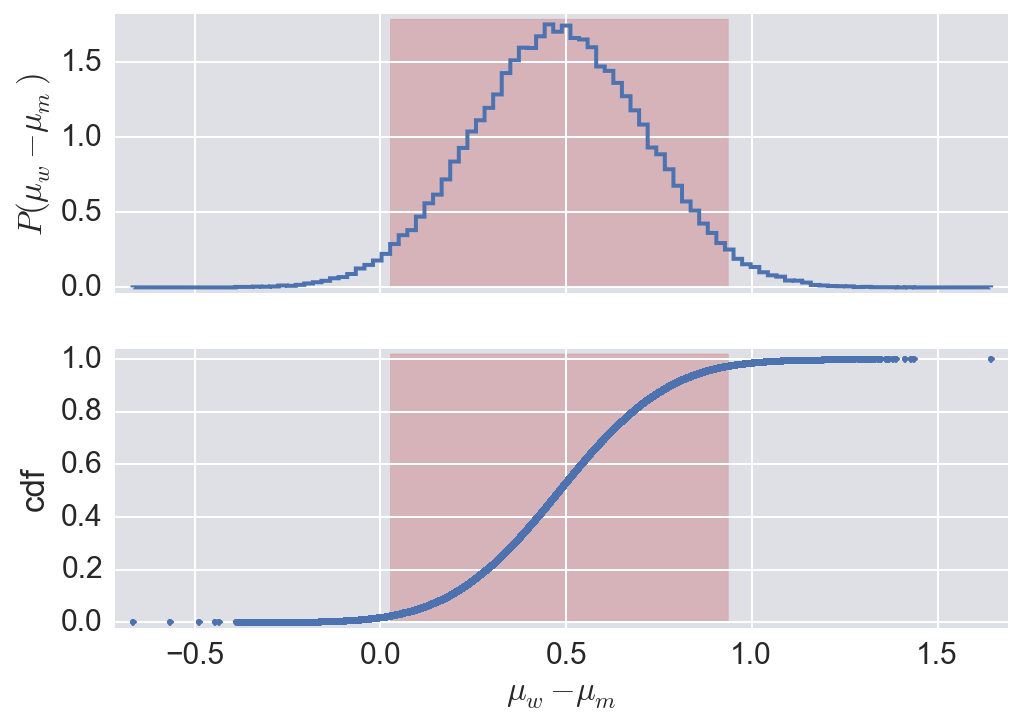

In [27]:
# Compute 95% confidence interval
conf_int = np.percentile(diff_samples, (2.5, 97.5))
print("""
95% confidence interval for µw - µm = [{0:.2f}, {1:.2f}] min
""".format(*tuple(conf_int)))

# Generate CDF
x = np.sort(diff_samples)
y = np.arange(len(diff_samples)) / len(diff_samples)

# Make plots
fig, ax = plt.subplots(2, 1, sharex=True)
_ = ax[0].hist(diff_samples, normed=True, bins=100, lw=2, histtype='step')
ax[0].set_ylabel(r'$P(\mu_w - \mu_m)$')
ax[0].margins(0.02)

ax[1].plot(x, y, '.')
ax[1].set_ylabel('cdf')
ax[1].set_xlabel(r'$\mu_w - \mu_m$')
ax[1].margins(0.02)

# Shade confidence interval
for i in [0,1]:
    ax[i].fill_between(x, 0.0, ax[i].get_ylim()[1], 
                       where=((0.025 < y) & (y < 0.975)), 
                       color=sns.color_palette()[2], alpha=0.3, zorder=0) 

We could also compute the confidence interval using a nonparametric bootstrap.


95% confidence interval for µw - µm = [0.08, 0.89] min



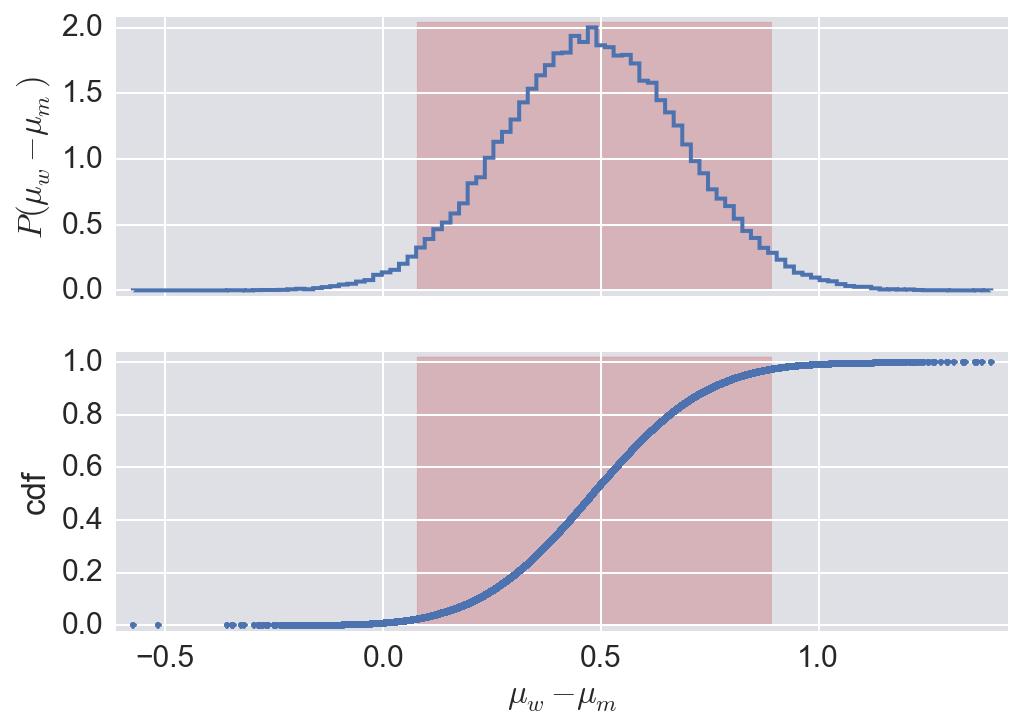

In [28]:
def bootstrap_repeated_measurements(x, stat_fun, args=(), n_trials=1000):
    """
    Get bootstrap samples of a statistic from repeated
    measurements `x`.  `stat_fun` must be of the form
    stat_fun(x, *args).
    """
    # Indices that we use for resampling
    inds_to_choose = np.arange(len(x), dtype=int)   
    
    # Samples to save
    samples = np.empty(n_trials)
    
    return np.array(
        [stat_fun(x[np.random.choice(inds_to_choose, len(x), replace=True)])
                   for _ in range(n_trials)])

# "Repeat" experiment
samples_wt = bootstrap_repeated_measurements(wt, np.mean, n_trials=100000)
samples_mut = bootstrap_repeated_measurements(mut, np.mean, n_trials=100000)

# Compute differences in the mean
diff_samples = samples_wt - samples_mut

# Compute 95% confidence interval
conf_int = np.percentile(diff_samples, (2.5, 97.5))
print("""
95% confidence interval for µw - µm = [{0:.2f}, {1:.2f}] min
""".format(*tuple(conf_int)))

# Generate CDF
x = np.sort(diff_samples)
y = np.arange(len(diff_samples)) / len(diff_samples)

# Make plots
fig, ax = plt.subplots(2, 1, sharex=True)
_ = ax[0].hist(diff_samples, normed=True, bins=100, lw=2, histtype='step')
ax[0].set_ylabel(r'$P(\mu_w - \mu_m)$')
ax[0].margins(0.02)

ax[1].plot(x, y, '.')
ax[1].set_ylabel('cdf')
ax[1].set_xlabel(r'$\mu_w - \mu_m$')
ax[1].margins(0.02)

# Shade confidence interval
for i in [0,1]:
    ax[i].fill_between(x, 0.0, ax[i].get_ylim()[1], 
                       where=((0.025 < y) & (y < 0.975)), 
                       color=sns.color_palette()[2], alpha=0.3, zorder=0) 

The bootstrap interval is a bit tighter because Gaussianity was not assumed.

**c)** Because we need speed later, we will not use MCMC to get our Bayesian estimate of the mean, but instead do some analytical work ahead of time and then use optimization.

We have two data sets, $D_w$ and $D_m$ which we assume to be drawn from independent Gaussian processes with differing means and differing variances.  Assuming a Jeffreys prior on the parameters, our posterior is

\begin{align}
P(\mu_w,\sigma_w,\mu_m,\sigma_m\mid D_w,D_m,I) &\propto\frac{1}{\sigma_w\sigma_m}
\left(\prod_{i\in D_w} \frac{\mathrm{e}^{-(x_i-\mu_w)^2/2\sigma_w^2}}{\sqrt{2\pi\sigma_w^2}}\right)
\left(\prod_{i\in D_m} \frac{\mathrm{e}^{-(x_i-\mu_m)^2/2\sigma_m^2}}{\sqrt{2\pi\sigma_m^2}}\right) \\[1em]
&\!\!\!\!\!\!\!\!\!\!\propto
\frac{1}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\,\exp\left[
-\frac{1}{2\sigma_w^2}\sum_{i\in D_w}(x_i-\mu_w)^2
-\frac{1}{2\sigma_m^2}\sum_{i\in D_m}(x_i-\mu_m)^2
\right]
\end{align}

We saw in [lecture 2](http://bebi103.caltech.edu/2015/lecture_notes/l02_parameter_estimation.pdf) that

\begin{align}
\sum_{i\in D}(x_i-\mu)^2 = n(\bar{x} - \mu)^2 + nr^2,
\end{align}

where $\bar{x}$ is the sample mean and $r^2$ is the sample variance.  Thus, we can write our posterior as

\begin{align}
P(\mu_w,\sigma_w,\mu_m,\sigma_m\mid D_w,D_m,I) &\propto
\frac{\mathrm{e}^{-n_w r_w^2/2\sigma_w^2}\,\mathrm{e}^{-n_m r_m^2/2\sigma_m^2}}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\\[1em]
&\;\;\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(\mu_w-\bar{x}_w\right)^2
-\frac{n_m}{2\sigma_m^2}\left(\mu_m-\bar{x}_m\right)^2
\right].
\end{align}

We now make a change of variables.  Let $\delta = \mu_w-\mu_m$ and $\gamma = \mu_w + \mu_m$.  Then, $\mu_w = (\gamma + \delta) / 2$ and $\mu_m = (\gamma - \delta) / 2$.  When we apply the change of variables formula, we only get a constant factor of $1/2$ multiplying the posterior, so we have

\begin{align}
P(\gamma, \delta, \sigma_w, \sigma_m\mid D_w, D_m, I) \propto
&\frac{\mathrm{e}^{-n_w r_w^2/2\sigma_w^2}\,\mathrm{e}^{-n_m r_m^2/2\sigma_m^2}}{\sigma_w^{n_w+1}\sigma_m^{n_m+1}}\\[1em]
&\;\;\times \exp\left[
-\frac{n_w}{2\sigma_w^2}\left(\frac{\gamma + \delta}{2}-\bar{x}_w\right)^2
-\frac{n_m}{2\sigma_m^2}\left(\frac{\gamma - \delta}{2}-\bar{x}_m\right)^2
\right].
\end{align}

So, the log posterior is

\begin{align}
\ln P(\gamma, \delta, \sigma_w, \sigma_m\mid D_w, D_m, I) =&\;\text{constant} - (n_w+1) \ln \sigma_w - (n_m+1)\ln \sigma_m
- \frac{n_w r_w^2}{2\sigma_w^2} - \frac{n_m r_m^2}{2\sigma_m^2} \\[1em]
&\;\;- \frac{n_w}{2\sigma_w^2}\left(\frac{\gamma + \delta}{2}-\bar{x}_w\right)^2
- \frac{n_m}{2\sigma_m^2}\left(\frac{\gamma - \delta}{2}-\bar{x}_m\right)^2.
\end{align}

Clearly, regardless of the value of $\sigma_m$ and $\sigma_w$, the log posterior is maximal when $\delta = \bar{x}_w - \bar{x}_m$ and $\gamma = \bar{x}_w + \bar{x}_m$.  Given that this, the last two terms in the log posterior are zero at the MAP.  We can then solve for the MAP values of $\sigma_m$ and $\sigma_w$ analytically by differentiated and setting equal to zero.  For $\sigma_w$, for example,

\begin{align}
\frac{\partial \ln P}{\partial \sigma_w} = -\frac{n_w+1}{\sigma_w} 
+ \frac{n_w r_w^2}{\sigma_w^3}.
\end{align}

Setting this equal to zero and solving for $\sigma_w$ gives the result that

\begin{align}
\sigma_w^* = \sqrt{\frac{n_w}{n_w+1} r_w^2}.
\end{align}

Note that this is different from the frequentist unbiased estimator.  We are choosing the value of $\sigma_w$ at the MAP, not $\sqrt{\langle \sigma_w^2\rangle}$, which is what the frequentist unbiased estimator is after.

Now that we have the MAP, we just have to find the Hessian of the log posterior, take the negative of its inverse, and we have the covariance matrix.  This involves significant algebraic grunge I do not presently wish to sully my hands doing.  I will just use numerical differentiation to do it, but the analytical result is that
\begin{align}
\delta = \bar{x}_w - \bar{x}_m \pm \sqrt{\frac{r_m^2}{1+n_m} + \frac{r_w^2}{1+n_w}}.
\end{align}

We will derive a result like this later in a clearer fashion in lecture when we do error propagation.  For now, I will take this as given.  We will take our credible region to be ± 2 standard deviations, which contains 95% of the probability under the Gaussian approximation of the posterior.

All of this analytical work was not really necessary, as we can just lean on efficient numerical methods instead.  I will use those going forward.  Since we need to specify bounds on the parameters in part (e) during model selection, I include more detail that necessary in the prior here.  The details will be explained in part (e).

In [29]:
def log_likelihood_diff(p, x, y):
    """
    Log likelihood for two Gaussian processes.  
    Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    # Unpack parameters
    gamma, delta, sigma_x, sigma_y = p
    
    # Compute mu's from gamma and delta
    mu_x = (gamma - delta) / 2
    mu_y = (gamma + delta) / 2
    
    return -len(y) * np.log(sigma_y) - len(x) * np.log(sigma_x) \
           - len(y) / 2 / sigma_y**2 * ((mu_y - y.mean())**2 + y.var()) \
           - len(x) / 2 / sigma_x**2 * ((mu_x - x.mean())**2 + x.var())
        
        
def log_prior_diff(p, mu_min=0, mu_max=600, sigma_min=1e-2, sigma_max=200):
    """
    Log prior for two Gaussian processes.  
    Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    #  Unpack
    gamma, delta, sigma_x, sigma_y = p
    
    # Compute mu's from gamma and delta
    mu_x = (gamma - delta) / 2
    mu_y = (gamma + delta) / 2
    
    # Check ranges
    if not ((mu_min < mu_x < mu_max) and (mu_min < mu_y < mu_max)):
        return -np.inf
    
    if not ((sigma_min < sigma_x < sigma_max) 
            and (sigma_min < sigma_y < sigma_max)):
        return -np.inf
    
    # Compute log prior
    return -np.log(2) - 2 * np.log(mu_max - mu_min) \
            - 2 * np.log(np.log(sigma_max / sigma_min)) \
            - np.log(sigma_x) - np.log(sigma_y)


def log_posterior_diff(p, x, y, mu_min=0, mu_max=600, 
                       sigma_min=1e-2, sigma_max=200):
    """
    Log posterior for two Gaussian processes.  Parameters are:
        gamma = mu_y + mu_x
        delta = mu_y - mu_x
        sigma_x
        sigma_y
    """
    lp = log_prior_diff(p, mu_min, mu_max, sigma_min, sigma_max)
    if lp == -np.inf:
        return -np.inf
    return lp + log_likelihood_diff(p, x, y)

    
def neg_log_posterior_diff(p, x, y, mu_min, mu_max, sigma_min, sigma_max):
    return -log_posterior_diff(p, x, y, mu_min, mu_max, sigma_min, sigma_max)

    
def two_gaussian_process_map(x, y, p0=None, mu_min=0, mu_max=600,
                             sigma_min=1e-2, sigma_max=200):
    """
    Given two samples from independent data sets, $x$ and $y$, compute
    MAP
    """
    # Get initial guess close to expected MAP
    if p0 is None:
        mu_x = x.mean()
        mu_y = y.mean()
        gamma_0 = (mu_y + mu_x) / 2
        delta_0 = (mu_y - mu_x) / 2
        p0 = np.array([gamma_0, delta_0, x.std(), y.std()])
        
    # Specify arguments to pass to log posterior
    args = (x, y, mu_min, mu_max, sigma_min, sigma_max)
    
    # Find the MAP
    res = scipy.optimize.minimize(neg_log_posterior_diff, p0, args=args, 
                                  method='powell')
    return res.x


def popt_and_cov(x, y, p0=None, mu_min=0, mu_max=600, 
                 sigma_min=1e-2, sigma_max=200):
    """
    Compute MAP for parameter delta = mu_y - mu_x and 
    its error bar (times error_bar_factor).
    """
    # Get MAP
    popt = two_gaussian_process_map(x, y, p0, mu_min, mu_max, 
                                    sigma_min, sigma_max)
    
    # Compute covariance matrix
    hes_fun = ndt.Hessian(log_posterior_diff)
    hes = hes_fun(popt, x, y, mu_min, mu_max, sigma_min, sigma_max)
    cov = -np.linalg.inv(hes)

    # Return parameters and covariance matrix
    return popt, cov

We'll now calculated our estimate with a 95% credible region.

In [30]:
popt, cov = popt_and_cov(mut, wt)

print("""
     δ MAP = {0:.2f} min
δ conf int = [{1:.2f}, {2:.2f}] min
""".format(popt[1], popt[1] - 2 * np.sqrt(cov[1,1]),
           popt[1] + 2 * np.sqrt(cov[1,1])))


     δ MAP = 0.48 min
δ conf int = [0.08, 0.89] min



The Bayesian credible region is a little tighter.  This is due to approximating the posterior as a Gaussian, where the marginalized posterior is actually a Student-t distribution, which is a bit broader than a Gaussian.

**d)** To perform the frequentist hypothesis test, we perform permutation, just like in [Tutorial 6b](http://bebi103.caltech.edu/tutorials/t6b_frequentist_hypothesis_testing.html), and look at the difference in means.  We borrow functions from that tutorial and let 'er rip.

In [31]:
def permute_sample(x, y, stat_fun, args=(), n_trials=1000):
    """
    Considered two arrays `x` and `y` as one and then selects
    random samples out of the combined array the same size as
    the original `x` and `y`.  The computes test statistic for each
    sample.
    """
    # Array to store samples
    samples = np.empty(n_trials)

    # Put the two data sets together
    vals = np.concatenate((x, y))
    
    for i in range(n_trials):
        # Permute and compute difference in means
        vals = np.random.permutation(vals)
        samples[i] = stat_fun(vals[:len(x)], vals[len(x):], *args)
        
    return samples

def p_value_from_samples(samples, actual, greater_or_less='greater'):
    """
    Compute probability that actual values if either greater than
    or less than samples value.
    """
    
    # Compute p-value
    if greater_or_less == 'greater':
        return np.sum(samples >= actual) / len(samples)
    else:
        return np.sum(samples <= actual) / len(samples)
    
# Function for difference in means
def mean_diff(x, y, return_abs=False):
    diff = y.mean() - x.mean()
    if return_abs:
        return np.abs(diff)
    return diff

# Do the sampling and compute the p-value
samples = permute_sample(mut, wt, mean_diff, n_trials=100000)
p = p_value_from_samples(samples, mean_diff(mut, wt))

# Print result
print("""p-value = {0:.6f}""".format(p))

p-value = 0.017910


So, we get a p-value of 0.02, below the "magic" value of 0.05, so we might say that the difference in means in the two samples is statistically significant.

**e)** To compute the Bayesian odds ratio, we will use the approximate expression derived in lecture.

\begin{align}
O_{01} \approx &\left(\frac{P(H_0\mid I)}{P(H_1\mid I)}\right)
\left(\frac{P(D\mid \mu^*, \sigma^*, H_0, I)}{P(D_1, D_2\mid \mu_w^*, \sigma_w^*, \mu_m^*, \sigma_m^*, H_1, I)}\right) \\[1em]
&\;\;\;\;\times
\left(\frac{P(\mu^*, \sigma^* \mid H_0, I) \,2\pi\,\sqrt{\det\boldsymbol{\sigma_0^2}}}
{P(\mu_w^*, \sigma_w^*, \mu_m^*, \sigma_m^*\mid H_2, I)\,(2\pi)^2 \sqrt{\det\boldsymbol{\sigma}_1^2}}\right),
\end{align}

I will take $P(H_0\mid I)/P(H_1\mid I) \approx 1$, assuming that we do not favor either model a priori.  To do the calculation, we need to compute the MAP and covariance for $H_0$, where the samples come from the same distribution.  To compute the other portions, we first consider the likelihood, prior, and posterior for Gaussian distributed data.  We'll start with the properly normalized Jeffreys prior.

\begin{align}
P(\mu,\sigma\mid I) = \frac{1}{\mu_\mathrm{max} - \mu_\mathrm{min}} \,
\frac{1}{\sigma\ln\left(\sigma_\mathrm{max}/\sigma_\mathrm{min}\right)}.
\end{align}

Thus, we have a log prior of

\begin{align}
\ln P(\mu,\sigma\mid I) = -\ln\left(\mu_\mathrm{max} - \mu_\mathrm{min}\right)
- \ln\left(\ln\left(\sigma_\mathrm{max}/\sigma_\mathrm{min}\right)\right)
- \ln \sigma.
\end{align}

Here, we have specified the bounds on $\mu$ and $\sigma$.  What might be reasonable in the present context?  Well, obviously, $0 \le \mu \le 600$ minutes, since the length of a sleep bout must be nonnegative and there are 600 total minutes in the third night.  We could try to constrain $\mu$ further, but these are hard physical limits.  How about $\sigma$?  Again, the standard deviation cannot be bigger than the actual night, so 600 is a hard upper bound.  For the lower bound, we might pick one second, since that is close to the sampling rate of the experiment.  So, $\sigma_\mathrm{min} = 1/60$.

Now, let's look at the likelihood.

\begin{align}
P(D\mid \mu, \sigma, I) = \left(\frac{1}{2\pi\sigma^2}\right)^{n/2}\,
\exp\left[-\frac{1}{2\sigma^2}\sum_{i\in D} (x_i - \mu)^2\right],
\end{align}

giving a log likelihood of

\begin{align}
\ln P(D\mid \mu, \sigma, I) = -\frac{n}{2}\,\ln(2\pi) - n\ln\sigma - \frac{1}{2\sigma^2}\sum_{i\in D} (x_i - \mu)^2.
\end{align}

We saw in [lecture 2](http://bebi103.caltech.edu/2015/lecture_notes/l02_parameter_estimation.pdf) that

\begin{align}
\sum_{i\in D}(x_i-\mu)^2 = n(\bar{x} - \mu)^2 + nr^2,
\end{align}

where $\bar{x}$ is the sample mean and $r^2$ is the sample variance.  So, we can write the log likelihood as

\begin{align}
\ln P(D\mid \mu, \sigma, I) = -\frac{n}{2}\,\ln(2\pi) - n\ln\sigma - \frac{n(\bar{x} - \mu)^2 + nr^2}{2\sigma^2}
\end{align}

Thus, the log posterior is

\begin{align}
\ln P(\mu, \sigma\mid D, I) = \text{constant} - (n+1)\ln\sigma - \frac{n(\bar{x} - \mu)^2 + nr^2}{2\sigma^2},
\end{align}

a familiar sight.  We can solve analytically for the MAP.  First, we see immediately that no matter what value $\sigma$ takes on, the log posterior is maximized when $\mu^* = \bar{x}$, which we already knew from lecture.  Now, differentiating with respect to $\sigma$, we get

\begin{align}
\frac{\partial\ln P(\mu, \sigma\mid D, I)}{\partial \sigma} = 
 -\frac{n+1}{\sigma} 
+ \frac{n r^2}{\sigma^3},
\end{align}

where we have used the fact that $\mu^* = \bar{x}$ at the MAP.  Setting this equal to zero and solving for $\sigma$ gives the result that

\begin{align}
\sigma^* = \sqrt{\frac{n}{n+1} r^2}.
\end{align}

Now that we have our MAP, we can compute the covariance matrix, first finding the Hessian at the MAP.  To do so, we compute the second derivatives and evaluate them at the MAP, with $\mu = \bar{x}$ and $\sigma^2 = nr^2/(n+1)$.  It is conveniently diagonal (a feature of Gaussians).

\begin{align}
\mathsf{H} = -\begin{pmatrix}
\frac{n+1}{nr^2} & 0 \\
0 & \frac{(n+1)^2(n-3)}{n^3 r^2}
\end{pmatrix}.
\end{align}

This matrix is easily inverted, giving

\begin{align}
\boldsymbol{\sigma}^2 = \begin{pmatrix}
\frac{nr^2}{n+1} & 0 \\
0 & \frac{n^3 r^2}{(n+1)^2(n-3)}
\end{pmatrix}.
\end{align}

The determinant is then

\begin{align}
\det \boldsymbol{\sigma}^2 = \frac{n^4r^4}{(n+1)^3(n-3)}.
\end{align}

Now, if we have two separate independent processes as we do with $H_1$, the likelihood, prior, and posterior probabilities of each process multiply, so their logarithms add.  The MAP is found by finding the MAP of each independent Gaussian, and the determinant of the covariance matrix is just the product of the determinant of the respective single-process covariances.

So, we just need to code up log likelihoods, log priors, and covariance matrices for a single Gaussian and then we add them up to get two separate measurements.

In [32]:
def log_prior(p, mu_min, mu_max, sigma_min, sigma_max):
    """
    Log prior for a Gaussian likelihood/Jeffreys prior.
    """
    mu, sigma = p
    
    if not ((mu_min < mu < mu_max) and (sigma_min < sigma < sigma_max)):
        return -np.inf
    
    return -np.log(mu_max - mu_min) - np.log(np.log(sigma_max / sigma_min)) \
            - np.log(sigma)

    
def log_likelihood(p, x):
    """
    Gaussian log likelihood.
    """
    mu, sigma = p
    
    return len(x) / 2 * np.log(2*np.pi) - len(x) * np.log(sigma) \
                - len(x) * ((x.mean() - mu)**2 + x.var()) / 2 / sigma

    
def gauss_map(x):
    """
    Return MAP as np.array([mu, sigma])
    """
    return np.array([x.mean(), x.var() * len(x) / (len(x) + 1)])


def gauss_det_cov(x):
    """
    Returns determinant of covariance matrix.
    """
    n = len(x)
    return n**4 * x.var()**2 / (n + 1)**3 / (n - 3)

Now that we have these, we can compute the odds ratio.  We'll do it piece by piece.

In [33]:
def log_odds_ratio(x, y, mu_min, mu_max, sigma_min, sigma_max, 
                   log_prior_ratio=0):
    """
    Compute odds ratio for single process versus two
    processes with Gaussian likelihoods.
    """
    # Specify bounds on parameters
    bounds = (mu_min, mu_max, sigma_min, sigma_max)

    # Put data into one array for hypothesis zero
    z = np.concatenate((x, y))

    # Compute MAP for H0
    popt_0 = gauss_map(z)

    # Compute MAP for WT
    popt_x = gauss_map(x)

    # Compute MAP for mutant
    popt_y = gauss_map(y)

    # Log goodness of fit ratio
    log_goodfit = log_likelihood(popt_0, z) - log_likelihood(popt_x, x) \
                    - log_likelihood(popt_y, y)

    # Log of Occam factor
    log_occam_0 = log_prior(popt_0, *bounds) + np.log(2*np.pi) \
                        + np.log(gauss_det_cov(z)) / 2

    log_occam_1 = log_prior(popt_x, *bounds) + np.log(gauss_det_cov(x)) / 2 \
                  + log_prior(popt_y, *bounds) + np.log(gauss_det_cov(y)) / 2 \
                  + 2 * np.log(2*np.pi)

    log_occam = log_occam_0 - log_occam_1

    # Compute log odds ratio
    log_odds = log_prior_ratio + log_goodfit + log_occam
    
    # Return results
    return log_goodfit, log_occam, log_odds

Let's see what we get for the log odds ratio!

In [34]:
print("""
Goodness of fit ratio: {0:.5f}
          Occam ratio: {1:.5f}
           Odds ratio: {2:.5f}
""".format(*tuple(np.exp(log_odds_ratio(wt, mut, 0, 600, 1/60, 600)))))


Goodness of fit ratio: 0.00021
          Occam ratio: 913.59217
           Odds ratio: 0.19009



We see that $H_1$ describes the data much better, but it takes a hit with the Occam factor.  This hit would be less if we reduces our acceptable range of $\mu$.  Say we chose one hour instead of 10 hours.  I would be pretty sure a fish was dead if it didn't move for ten hours.  Indeed, a factor of 10 decreases in the range of $\mu$ is about a factor of ten decrease in the odds ratio, favoring $H_1$.

In [35]:
print("""
Goodness of fit ratio: {0:.5f}
          Occam ratio: {1:.5f}
           Odds ratio: {2:.5f}
""".format(*tuple(np.exp(log_odds_ratio(wt, mut, 0, 60, 1/60, 60)))))


Goodness of fit ratio: 0.00021
          Occam ratio: 71.30804
           Odds ratio: 0.01484



Now, we see about 100 to one odds that the mutant and wild type are two separate processes.  These odds ratios are not as overwhelming as ones we've seen previously, but nonetheless argue in favor of model $H_1$.  Going forward, we will assume a 60-minute bound on $\mu$.

In [36]:
def new_data(mu, var, n):
    """
    Generate new data
    """
    return np.maximum(np.random.normal(mu, np.sqrt(var), n), 0)

n_trials = 50000
n_new_data = 100
conf_int = np.empty((2,n_new_data))
cred_reg = np.empty((2, n_new_data))
odds = np.empty(n_new_data)
p_values = np.empty(n_new_data)

for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, var_wt, len(wt))
    new_mut = new_data(mu_mut, var_mut, len(mut))
    
    # Compute the observed mu and var
    new_mu_wt = new_wt.mean()
    new_var_wt = new_wt.var(ddof=1)
    new_mu_mut = new_mut.mean()
    new_var_mut = new_mut.var(ddof=1)
    
    # "Repeat" experiments
    samples_wt = gaussian_draw(new_mu_wt, np.sqrt(new_var_wt), np.mean, 
                               len(new_wt), n_trials=n_trials)
    samples_mut = gaussian_draw(new_mu_mut, np.sqrt(new_var_mut), np.mean, 
                                len(new_wt), n_trials=n_trials)

    # Compute differences in the mean
    diff_samples = samples_wt - samples_mut
    
    # Compute confidence interval
    conf_int[:,i] = np.percentile(diff_samples, (2.5, 97.5))
    
    # Compute Bayesian credible region
    popt, cov = popt_and_cov(new_mut, new_wt)
    cred_reg[:,i] = np.array([popt[1] - 2 * np.sqrt(cov[1,1]),
                              popt[1] + 2 * np.sqrt(cov[1,1])])

    # Compute p-value
    samples = permute_sample(new_mut, new_wt, mean_diff, n_trials=n_trials)
    p_values[i] = p_value_from_samples(samples, mean_diff(new_mut, new_wt))
    
    # Compute odds ratio
    odds[i] = np.exp(log_odds_ratio(new_wt, new_mut, 0, 60, 1/60, 60)[-1])

In [45]:
# In case you'r worried about choice of p-value, let's do it with Welch's
n_new_data = 10000
p_values = np.empty(n_new_data)
for i in range(n_new_data):
    # Generate new data
    new_wt = new_data(mu_wt, var_wt, len(wt))
    new_mut = new_data(mu_mut, var_mut, len(mut))
    
    # Compute the observed mu and var
    new_mu_wt = new_wt.mean()
    new_var_wt = new_wt.var(ddof=1)
    new_mu_mut = new_mut.mean()
    new_var_mut = new_mut.var(ddof=1)

    p_values[i] = st.ttest_ind(new_wt, new_mut, equal_var=False)[1]

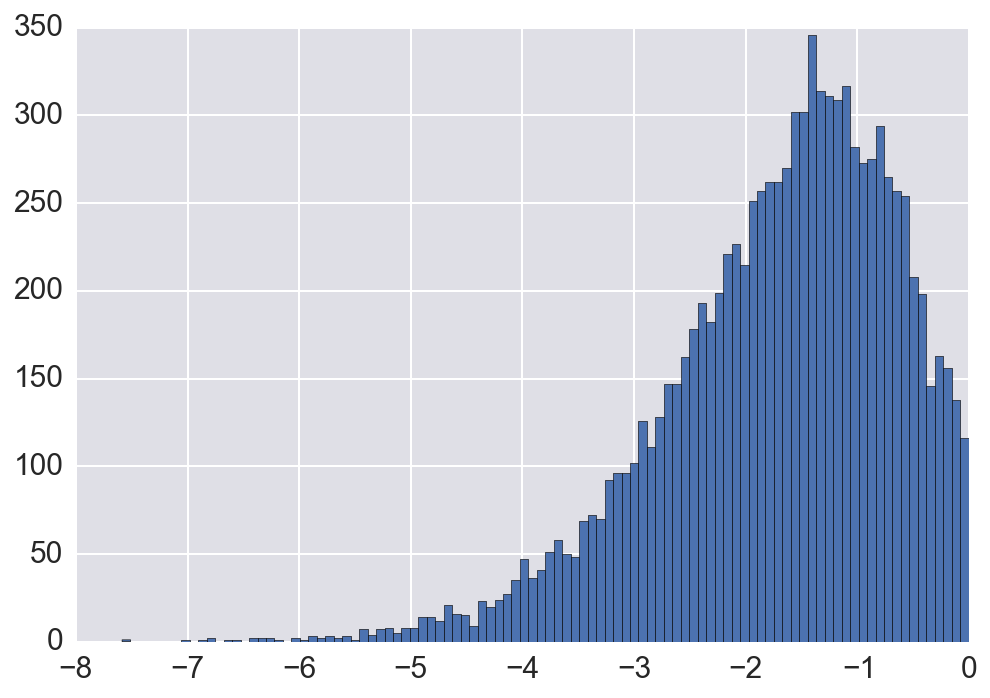

In [46]:
_ = plt.hist(np.log10(p_values), bins=100)

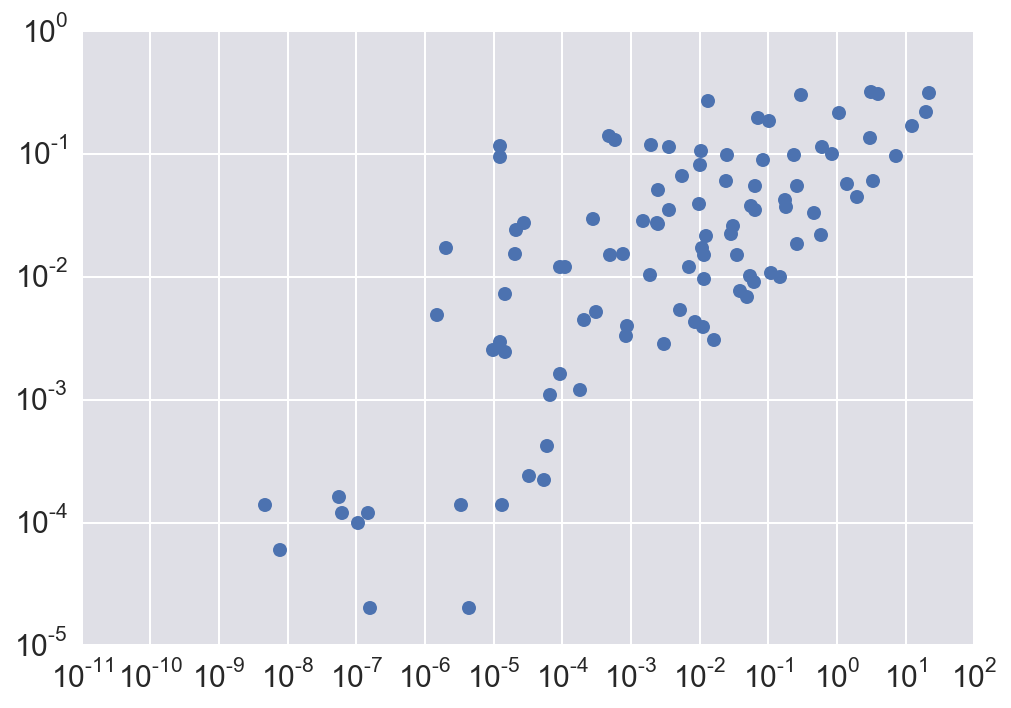

In [37]:
plt.loglog(odds, p_values, 'o')
# plt.semilogx(odds, np.arange(100), 'o')

In [ ]:
plt.plot(conf_int, np.vstack(2*[np.arange(100).reshape((1, 100))]), '-',
         color=sns.color_palette()[0]);

In [ ]:
plt.plot(cred_reg, np.vstack(2*[np.arange(100).reshape((1, 100))]), '-',
         color=sns.color_palette()[0]);

In [ ]:
n_trials = 50000
n_new_data = 100
conf_int = np.empty((2,n_new_data))
log_odds = np.empty(n_new_data)
p = np.empty(n_new_data)

# Start arrays for concatenation
new_wt = wt
new_mut = mut

for i in range(n_new_data):
    # Generate new data
    new_wt = np.concatenate((new_wt, new_data(mu_wt, var_wt, len(wt))))
    new_mut = np.concatenate((new_mut, new_data(mu_mut, var_mut, len(mut))))
    
#     # Compute the observed mu and var
#     new_mu_wt = new_wt.mean()
#     new_var_wt = new_wt.var(ddof=1)
#     new_mu_mut = new_mut.mean()
#     new_var_mut = new_mut.var(ddof=1)
    
#     # "Repeat" experiments
#     samples_wt = gaussian_draw(new_mu_wt, np.sqrt(new_var_wt), np.mean, 
#                                len(new_wt), n_trials=n_trials)
#     samples_mut = gaussian_draw(new_mu_mut, np.sqrt(new_var_mut), np.mean, 
#                                 len(new_wt), n_trials=n_trials)

#     # Compute differences in the mean
#     diff_samples = samples_wt - samples_mut
    
#     # Compute confidence interval
#     conf_int[:,i] = np.percentile(diff_samples, (2.5, 97.5))

#     # Compute p-value
#     samples = permute_sample(new_mut, new_wt, mean_diff, n_trials=n_trials)
#     p[i] = p_value_from_samples(samples, mean_diff(new_mut, new_wt))
    
    # Compute odds ratio
    log_odds[i] = log_odds_ratio(new_wt, new_mut, 0, 60, 1/60, 60)[-1]

In [ ]:
x_0 = np.sort(np.concatenate((new_wt, new_mut)))
y_0 = np.arange(len(x_0)) / len(x_0)
x_1 = np.sort(new_wt)
y_1 = np.arange(len(x_1)) / len(x_1)
x_2 = np.sort(new_mut)
y_2 = np.arange(len(x_2)) / len(x_2)

plt.plot(x_0, y_0, '.')
plt.plot(x_1, y_1, '.')
plt.plot(x_2, y_2, '.')

### Problem 5.2: Outliers in FRET binding curve

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imaging two proteins, $a$ and $b$ may bind to each other in the reaction

\begin{align}
ab \rightleftharpoons a + b
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of $a$ and $b$ to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed and measure $c_{ab}$ for various $c_b^0$.  We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$.  For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of $a$ is bound to $b$.  Specifically, we take $a$ with a fluorophore and $b$ is a receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molcule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume.  We define by $e$ the FRET efficiency,

\begin{align}
e = 1 - \frac{f}{f_0}.
\end{align}

If we measure $F_0$, the measured fluorescence when there is no b protein in the sample, we can compute the FRET efficiency from  the measured values $F$ and $F_0$

\begin{align}
e =  1 - \frac{c_a^0\,V f}{c_a^0\,Vf_0} = 1 - \frac{F}{F_0}.
\end{align}

Substituting in our expressions for $F$ and $F_0$, we get

\begin{align}
e = 1 - \frac{\left(c_a \,f_0 + c_{ab}\, f_q\right)V}{c_a^0\,V f_0}
= 1 - \frac{c_a}{c_a^0} - \frac{c_{ab}}{c_a^0}\,\frac{f_q}{f_0}.
\end{align}

Using the fact that $c_a^0 = c_a + c_{ab}$, this becomes

\begin{align}
e = \left(1-\frac{f_q}{f_0}\right)\frac{c_{ab}}{c_a^0}.
\end{align}

In other words, the FRET efficiency is proportional to the fraction of a that is bound, or

\begin{align}
e = \alpha \, \frac{c_{ab}}{c_a^0} = \frac{2\alpha\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}},
\end{align}

where $\alpha = 1-f_q/f_0$.  So, we perform a regression with two phenomenological parameters to fit, $\alpha$ and $K_d$.

**a)** Load in the data for one of these FRET efficiency titration curves.  You can download the data set [here](../data/fret_binding_curve.csv').  Compute the background-subtracted fluorescence and the FRET efficiency.  *These are real data, but they are from an unpublished experiment here on campus.  If you are interested in the proteins we are studying, please ask me and we can discuss.*

**b)** Perform regressions to find $K_d$ with and without an outlier detection scheme.  How do the results differ?

In [18]:
df = pd.read_csv('../data/blythe_et_al/fret_binding_curve.csv', comment='#')
df['bg_sub_fluor'] = df['fluorescence'] - df['buffer']
df['FRET efficiency'] = 1 - df['bg_sub_fluor'] \
                                / df[df['b conc (nM)']==0]['bg_sub_fluor'].values
inds = df['b conc (nM)'] > 0

ca0 = df[inds]['a conc (nM)'].values
cb0 = df[inds]['b conc (nM)'].values
e = df[inds]['FRET efficiency'].values

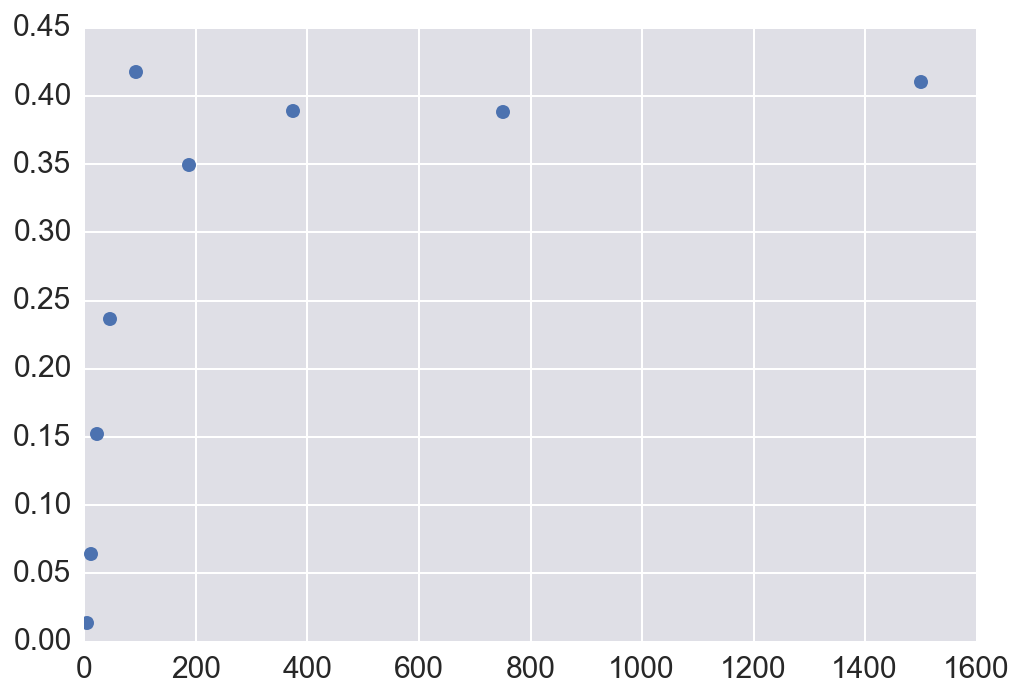

In [19]:
plt.plot(cb0, e, 'o')

In [16]:
df

,buffer,fluorescence,a conc (nM),b conc (nM),bg_sub_fluor,FRET efficiency
0,1256.5751,258316.2818,50,1500.000000,257059.7067,0.410066
1,1256.5751,267722.6277,50,750.000000,266466.0526,0.388479
2,1256.5751,267431.6620,50,375.000000,266175.0869,0.389147
3,1256.5751,284596.2914,50,187.500000,283339.7163,0.349756
4,1256.5751,254903.3958,50,93.750000,253646.8207,0.417899
5,1256.5751,333810.6371,50,46.875000,332554.0620,0.236812
6,1256.5751,370821.7778,50,23.437500,369565.2027,0.151874
7,1256.5751,408856.1424,50,11.718750,407599.5673,0.064588
8,1256.5751,431000.0000,50,5.859375,429743.4249,0.013770
9,1256.5751,437000.0000,50,0.000000,435743.4249,0.000000


In [ ]:
inds = (df['replicate'] == 'A') & (df['wavelength'] == 577)
df[inds][['buffer', 'fluorescence', 'p1 conc (nM)', 'p2 conc (nM)']].to_csv('fret_binding_curve.csv', index=False)

In [ ]:
df

In [ ]:
def fraction_bound(Kd, ca0, cb0):
    """
    Fraction bound
    """
    b = Kd + ca0 + cb0
    c = ca0 * cb0
    return 2 * c / (b + np.sqrt(b**2 - 4 * c))

def fret_efficiency(p, ca0, cb0):
    """
    Compute FRET efficiency
    """
    delta_G, alpha = p
    return alpha * fraction_bound(np.exp(delta_G), ca0, cb0)
                   

def log_posterior_cauchy(p, x, y, model_fun, beta, args=()):
    """
    JIT the hard part of the calculation for speed.
    """
    if beta < 0:
        return 0
    
    return -(len(x) + 1) * np.log(beta) \
            - np.sum(np.log(1.0 + ((y - model_fun(p, x, *args) / beta)**2))
                     
def log_posterior_cauchy

In [ ]:
df

In [ ]:
inds = (df['replicate'] == 'A') & (df['p2 conc (nM)'] == 1500)
plt.plot(df.loc[inds, 'wavelength'], df.loc[inds, 'fluorescence'])

In [ ]:
df.loc[inds, 'bg sub fluorescence']

In [ ]:
df['p2 conc (nM)'].unique()

In [ ]:
1500 / 2 ** r.str.lstrip('ABC').astype(int)

<br />

### Problem 3.4 Connections in the human brain
This problem may be viewed <a href="../protected/homework/hw3_protected.html#Problem-3.4-Connections-in-the-human-brain-(40-pts-extra-credit)">here</a>.